<b><font size="6">Techscape Project</font><a class="anchor"><a id='toc'></a></b><br>

# Import the needed libraries

In [1]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
techscape = pd.read_csv('train.csv')
print(techscape.shape)
techscape.head(3)

(9999, 17)


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0,0.0000,0.0667,0.0,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5,0.0217,0.0449,0.0,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0,0.0250,0.0583,0.0,Windows,4,Italy,1,Returner,0


# Check for missing data

In [3]:
techscape.info()
# There are now missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

# Change the types of the variables

In [4]:
# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 

techscape.Country = techscape.Country.astype('string') 

techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 

techscape.Type_of_Traffic = techscape.Type_of_Traffic.astype('string') 

techscape.Browser = techscape.Browser.astype('string') 


#techscape.info()

In [5]:
# Separate the metric variables from the non metric ones 
metric_features = techscape.select_dtypes(include=np.number).set_index(techscape.index).columns.to_list()
non_metric_features = techscape.select_dtypes(exclude=np.number).set_index(techscape.index).columns.to_list()

#non_metric_features

# Check for incoherencies in the data


In [6]:
# Date variable
print(f'Date of the web visit varies from {techscape.Date.min()} and {techscape.Date.max()}, excluding the month of April.')

Date of the web visit varies from 2020-02-01 00:00:00 and 2020-12-31 00:00:00, excluding the month of April.


# Não eliminar nenhuma incoerência !!

In [7]:
# Pages and Duration variables

# usually, it doeesn´t make sense that Pages > 0 and Duration = 0. However, there are too many observations like that,
# so, in instead of removing them, we decided to convert (duration = 0, pages=1)  --> (duration = 1, pages=1)

#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.drop(account_index, axis=0, inplace=True)
techscape.loc[techscape['AccountMng_Duration']==0,'AccountMng_Duration'] = 1
techscape

#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.drop(faq_index, axis=0, inplace=True)
techscape.loc[techscape['FAQ_Duration']==0,'FAQ_Duration'] = 1
techscape

#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.drop(product_index, axis=0, inplace=True)
techscape.loc[techscape['Product_Duration']==0,'Product_Duration'] = 1
#techscape

# Total removed = 3 + 9 + 130 = 142 (1.42%)

# Deal with the outliers

In [8]:
# Se descriptive statistics for all the variables
techscape.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Access_ID,9857,9857,598396466,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,9857,305,2020-05-25 00:00:00,118,2020-02-01,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountMng_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,2.353454,3.352719,0.0,0.0,1.0,4.0,27.0
AccountMng_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,82.729758,180.498648,1.0,1.0,9.5,94.0,3398.75
FAQ_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,0.513442,1.28642,0.0,0.0,0.0,0.0,24.0
FAQ_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,35.857203,140.539521,1.0,1.0,1.0,1.0,2549.375
Product_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,32.069494,44.734139,0.0,8.0,18.0,38.0,705.0
Product_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,1215.836554,1967.18977,0.5,197.0,612.625,1483.55,63973.5222
GoogleAnalytics_BounceRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.020057,0.044845,0.0,0.0,0.0029,0.016,0.2
GoogleAnalytics_ExitRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.041122,0.045789,0.0,0.0142,0.025,0.0481,0.2


### Plot the histograms of the numeric variables

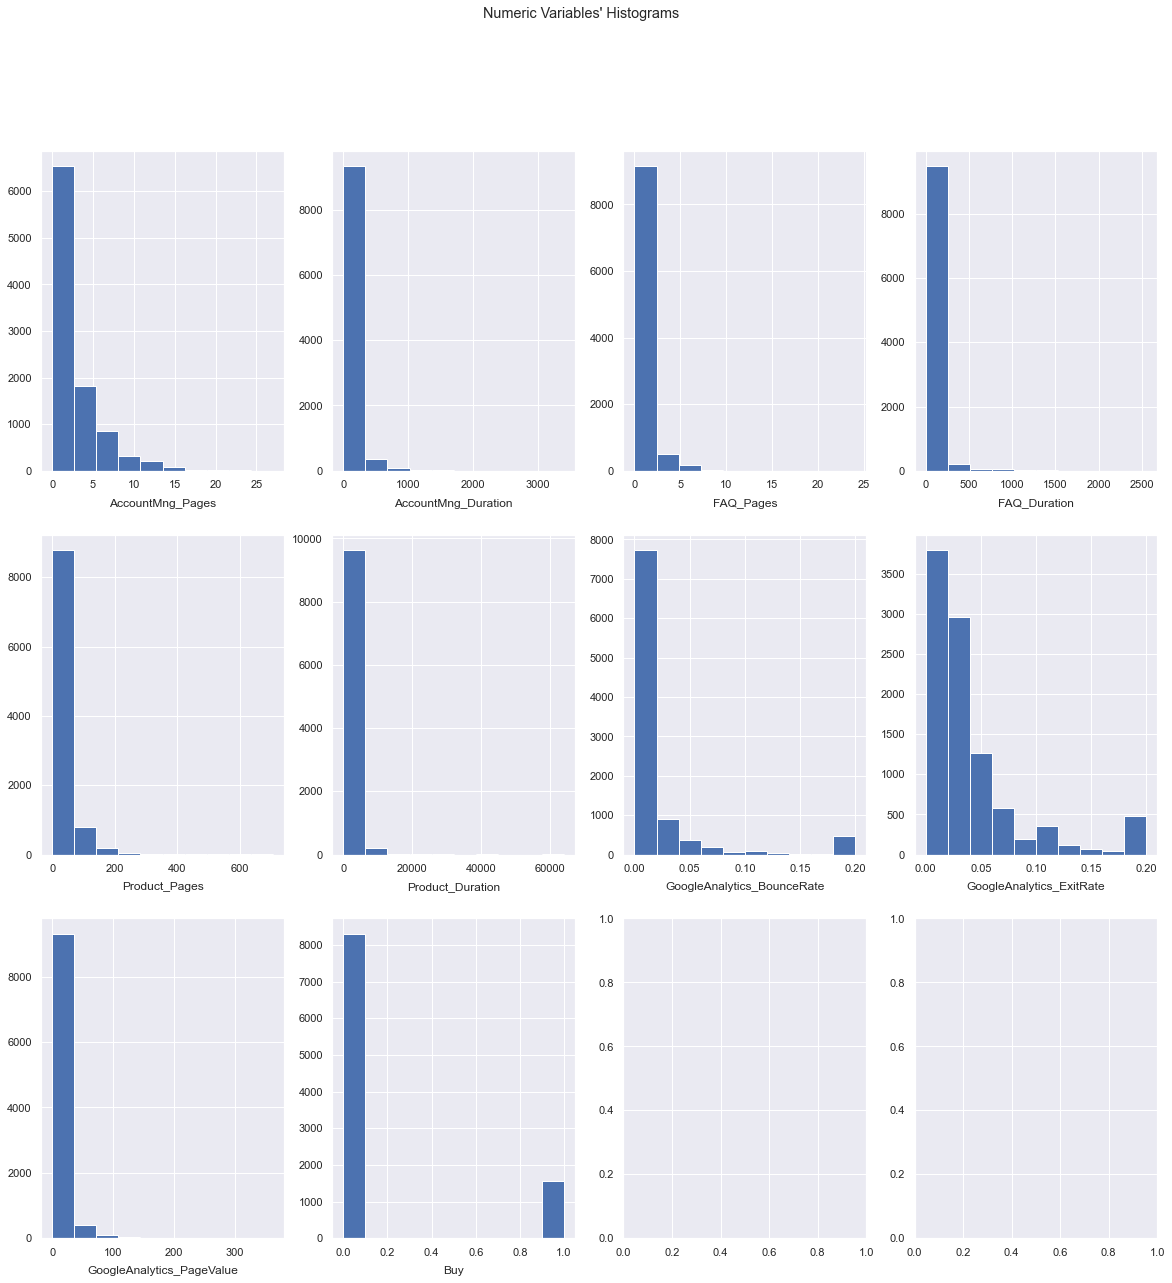

In [9]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, math.ceil(len(metric_features) / 3), figsize=(20,20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

### Plot the boxplots of the numeric variables

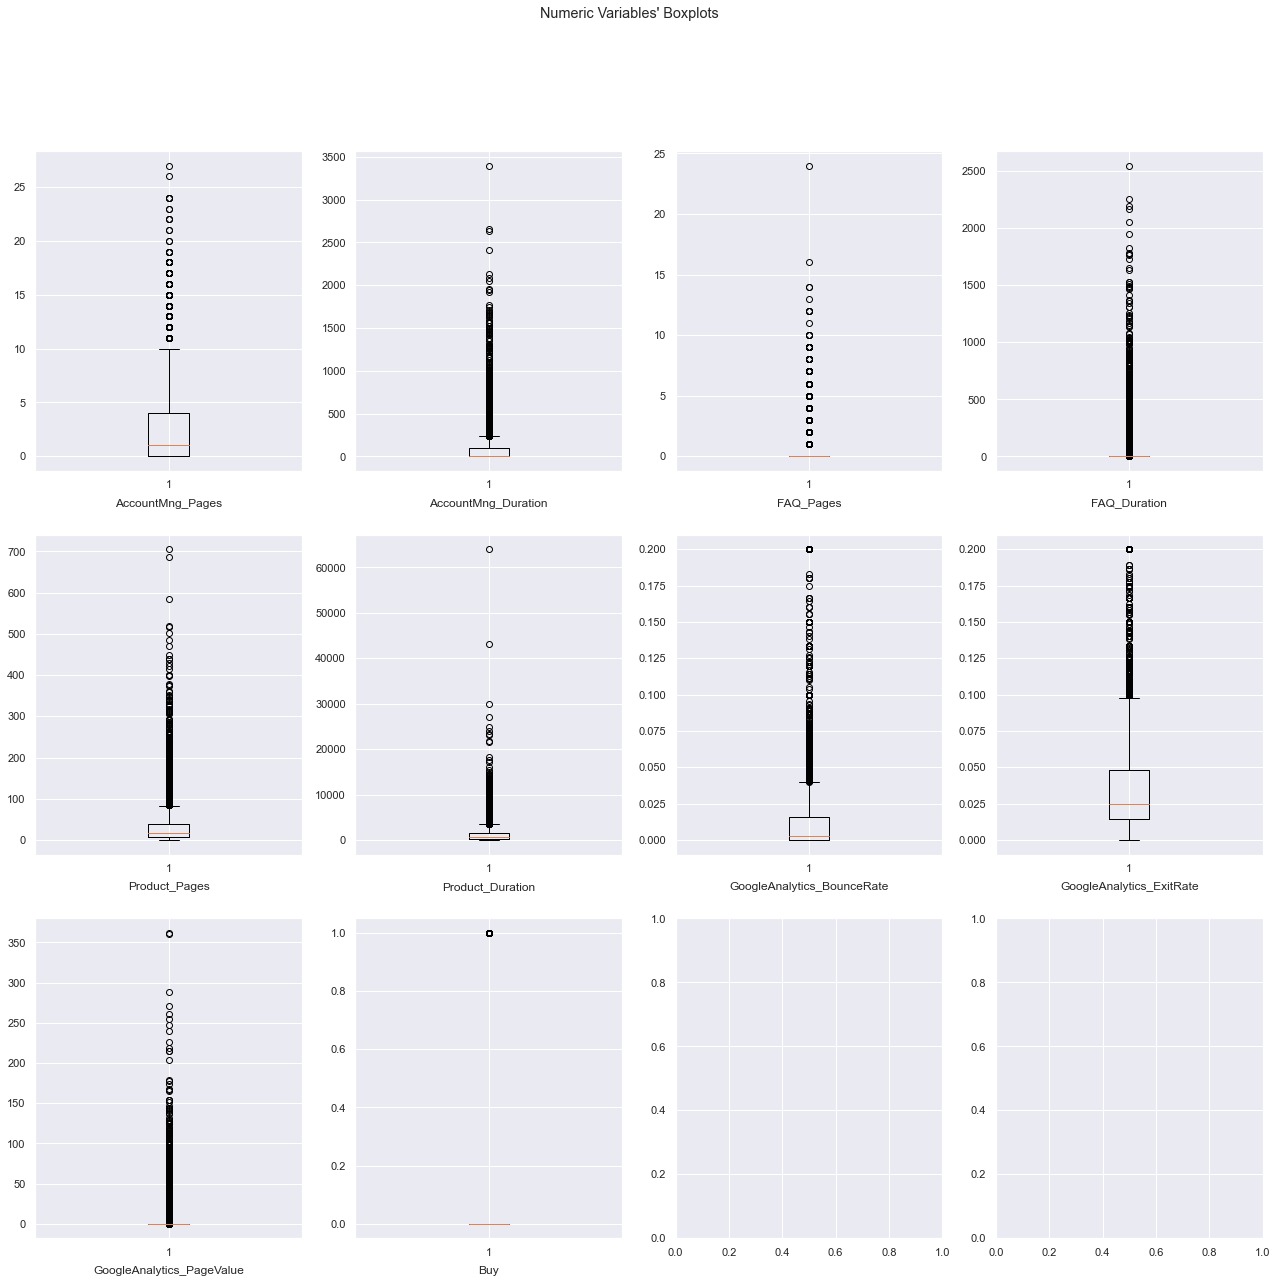

In [10]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, math.ceil(len(metric_features) / 3), figsize=(22, 20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.boxplot(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Boxplots"

plt.suptitle(title)

plt.show()

### Filter 1 to remove outliers - Manually

In [11]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (techscape['AccountMng_Pages']<= 10)  
    &
    (techscape['AccountMng_Duration']<= 1000)
    &
    (techscape['FAQ_Pages']<=7)
    &
    (techscape['FAQ_Duration']<=700)
    &
    (techscape['Product_Pages']<=350)
    &
    (techscape['Product_Duration']<=20000)
    &
    (techscape['GoogleAnalytics_BounceRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_ExitRate']<= 0.13)
    &
    (techscape['GoogleAnalytics_PageValue']<= 100)   
)

techscape_1 = techscape[filters1]

perc_outliers1 = np.round((techscape.shape[0] - techscape_1.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers1}%')

Percentage of observations removed: 12.1%


### Filter 2 to remove outliers - Interquantile Method

In [12]:
techscape_mean, techscape_std = np.mean(techscape), np.std(techscape)

# We can change the number of stds
upper_lim = techscape_mean + 5 * techscape_std   
lower_lim = techscape_mean - 5 * techscape_std

filters2 = []

for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    
    filters2.append(techscape[metric].between(llim, ulim, inclusive=True))
    

filters2 = pd.Series(np.all(filters2, 0))
filters2=filters2.values


techscape_2 = techscape[filters2]

perc_outliers2 = np.round((techscape.shape[0] - techscape_2.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers2}%')

Percentage of observations removed: 3.48%


### Filter 3 to remove outliers - Kmeans

In [13]:
data = techscape[metric_features]

# Get the inertia values from 2 to 15 clusters
nclusters=np.arange(2,15)
inertia = []

for i in nclusters:
    km = KMeans(n_clusters = i+1)
    clusters=km.fit_predict(data)
    inertia.append(km.inertia_)

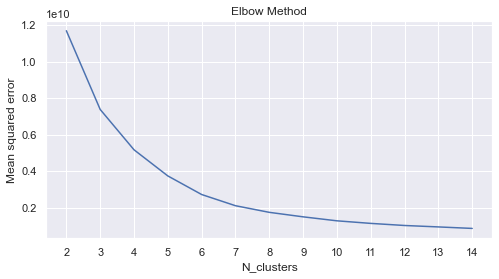

In [14]:
# Plot the Elbow Graphic
plt.figure(figsize=(8,4))
plt.plot(nclusters, inertia)
plt.xticks(nclusters)

plt.xlabel("N_clusters")
plt.ylabel("Mean squared error")
plt.title("Elbow Method")
plt.show()

In [15]:
# By looking into the elbow graphic we decided to select 4 centroids

# kmeans model, setting k = 4
km = KMeans(n_clusters = 4)
clusters=km.fit_predict(data)

# obtaining the centers of the clusters
centroids = km.cluster_centers_

# points array will be used to reach the index easy
points = np.empty((0,len(data.loc[0,:])), float)

# distances will be used to calculate outliers
distances = np.empty((0,data.shape[1]), float)

# getting points and distances
for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],data[clusters == i], 'euclidean')) 
    points = np.append(points, data[clusters == i], axis=0)
    
percentile = 80
# getting outliers whose distances are greater than some percentile
outliers = points[np.where(distances > np.percentile(distances, percentile))]

In [16]:
# Transform the dataframe into an ndarray
datanp = data.values

# Match outliers with each specific row
pairwise_compare = datanp == outliers[:, np.newaxis, :]
filters3 = ~pairwise_compare.all(axis=2).any(axis=0)

techscape_3 = techscape[filters3]

perc_outliers3 = np.round((techscape.shape[0] - techscape_3.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers3}%')

Percentage of observations removed: 20.01%


In [17]:
techscape_4 = techscape[(filters1 | filters2 | filters3)]

perc_outliers4 = np.round((techscape.shape[0] - techscape_4.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of outliers removed: {perc_outliers4}%')

Percentage of outliers removed: 2.3%


# Feature Engineering

In [18]:
# Create new variables

# Create binary variables for operating systems
techscape['Apple'] = techscape['OS'].apply(lambda x: bool(1) if x == 'MacOSX' or x == 'iOS' else bool(0))  
techscape['Windows'] = techscape['OS'].apply(lambda x: bool(1) if x == 'Windows' else bool(0))  
techscape['Android'] = techscape['OS'].apply(lambda x: bool(1) if x == 'Android' else bool(0))


# Create binary variables for countries
techscape['Portugal'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' else str(0)) 
techscape['Iberian_Peninsula'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' or x == 'Spain' else str(0))
techscape['Spain'] = techscape['Country'].apply(lambda x: str(1) if x == 'Spain' else str(0))


# Create binary variables for type of visitors
techscape['Returner'] = techscape['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'Returner' else bool(0)) 
techscape['New_Access'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'New_Access' else str(0))


# Create the total duration of the visits and total number of page visits
techscape['Total_Duration'] = techscape['AccountMng_Duration'] + techscape['FAQ_Duration'] + techscape['Product_Duration']
techscape['Total_Pages'] = techscape['AccountMng_Pages'] + techscape['FAQ_Pages'] + techscape['Product_Pages']

techscape.loc[techscape['Total_Pages']==0,'Total_Pages']=1


# Create the proportion of time on each page type
techscape['PropTime_AccountMng'] = techscape['AccountMng_Duration']/techscape['Total_Duration']
techscape['PropTime_FAQ'] = techscape['FAQ_Duration']/techscape['Total_Duration']
techscape['PropTime_Product'] = techscape['Product_Duration']/techscape['Total_Duration']

# Create the proportion of visited pages of each type
techscape['PropPages_AccountMng'] = techscape['AccountMng_Pages']/techscape['Total_Pages']
techscape['PropPages_FAQ'] = techscape['FAQ_Pages']/techscape['Total_Pages']
techscape['PropPages_Product'] = techscape['Product_Pages']/techscape['Total_Pages']

# Create the average time spent per page and type of page
techscape['AvgTimePerPage'] = techscape['Total_Duration'].div(techscape['Total_Pages'].values)

techscape['AvgTimeOnAccountMng'] = techscape['AccountMng_Duration'].div(techscape['AccountMng_Pages'].values)
techscape['AvgTimeOnFAQ'] = techscape['FAQ_Duration'].div(techscape['FAQ_Pages'].values)
techscape['AvgTimeOnProduct'] = techscape['Product_Duration'].div(techscape['Product_Pages'].values)

techscape.loc[techscape['AccountMng_Pages']==0,'AvgTimeOnAccountMng']=0
techscape.loc[techscape['FAQ_Pages']==0,'AvgTimeOnFAQ']=0
techscape.loc[techscape['Product_Pages']==0,'AvgTimeOnProduct']=0


### avg time per type of page?


# Create the month of the visit
techscape['Month'] = techscape['Date'].dt.month


# Create variable Covid
techscape['Covid'] = techscape['Month'].apply(lambda x: True if x>3 else False)


# Create dummy categorical variables

techscape['Month'] = techscape['Month'].apply(lambda x: calendar.month_abbr[x])
month = pd.DataFrame(pd.get_dummies(techscape['Month'], drop_first = True, dtype=bool))

techscape['Type_of_Traffic'] = techscape['Type_of_Traffic'].apply(lambda x: 'Traffic_'+str(x))
type_traffic = pd.DataFrame(pd.get_dummies(techscape['Type_of_Traffic'], drop_first = True, dtype=bool))

techscape['Browser'] = techscape['Browser'].apply(lambda x: 'Browser_'+str(x))
browser = pd.DataFrame(pd.get_dummies(techscape['Browser'], drop_first = True, dtype=bool))

techscape=pd.concat((techscape,month,type_traffic,browser), axis=1)


display(techscape.head(3))
print(techscape.shape)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Browser_11,Browser_12,Browser_13,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0,0.0000,0.0667,...,False,False,False,True,False,False,False,False,False,False
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5,0.0217,0.0449,...,False,False,False,True,False,False,False,False,False,False
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0,0.0250,0.0583,...,False,False,False,False,False,True,False,False,False,False


(9857, 73)


In [19]:
techscape.drop('OS', axis=1, inplace=True)
techscape.drop('Country', axis=1, inplace=True)
techscape.drop('Type_of_Visitor', axis=1, inplace=True)
techscape.drop('Browser', axis=1, inplace=True)
techscape.drop('Type_of_Traffic', axis=1, inplace=True)
techscape.drop('Date', axis=1, inplace=True)
techscape.drop('Access_ID', axis=1, inplace=True)
techscape.drop('Month', axis=1, inplace=True)

# Data Partition



In [54]:
# Define data as all the independent variables
data = techscape.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape['Buy']


# -----------------------
X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.75, stratify = target, random_state=5)
# Train 0.75 || Valid 0.25
# Stratify so we have the same values in target in the train and val datasets


# -----------------------
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)


#### Usam binárias como numéricas ??

In [55]:
# -------------- SCALLING --------------

scaler = MinMaxScaler().fit(X_train_metric)

X_train_metric_scaled = scaler.transform(X_train_metric)
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)

X_val_metric_scaled = scaler.transform(X_val_metric)
X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)

# Feature Selection

Filter Methods:

In [56]:
# ------------ Univariate Variables ------------

# Check if any of the variables is univariate
X_train_metric_scaled.var()

# There aren't univariate variables
# Keep: all
# Remove: none

AccountMng_Pages              0.015500
AccountMng_Duration           0.002856
FAQ_Pages                     0.003053
FAQ_Duration                  0.002811
Product_Pages                 0.003960
Product_Duration              0.000986
GoogleAnalytics_BounceRate    0.050431
GoogleAnalytics_ExitRate      0.052246
GoogleAnalytics_PageValue     0.002771
Total_Duration                0.000942
Total_Pages                   0.003889
PropTime_AccountMng           0.024023
PropTime_FAQ                  0.011072
PropTime_Product              0.041470
PropPages_AccountMng          0.015847
PropPages_FAQ                 0.002473
PropPages_Product             0.019957
AvgTimePerPage                0.001104
AvgTimeOnAccountMng           0.000917
AvgTimeOnFAQ                  0.001186
AvgTimeOnProduct              0.001202
dtype: float64

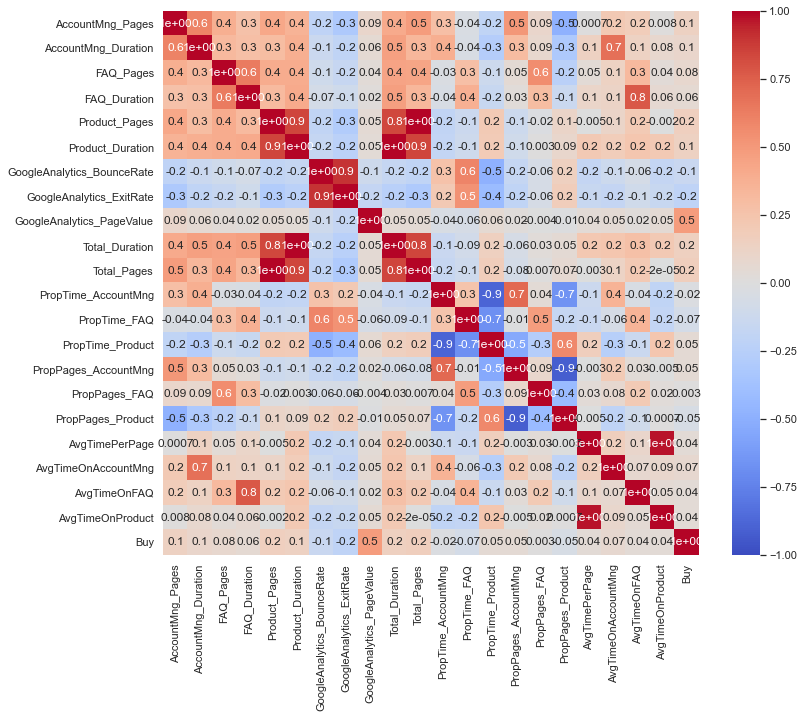

In [57]:
# ------------ Spearman Correlation ------------

# Check correlations
all_train_metric = X_train_metric_scaled.join(y_train)
all_train_metric.head()

corr = all_train_metric.corr(method = 'pearson')  # or spearman

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, vmin=-1, vmax=1, annot = True, cmap ="coolwarm" , fmt='.1')

    plt.show()
    
cor_heatmap(corr) 

In [58]:
# Better visualization of correlation values (numerical data)

corr.style.applymap(lambda x: 'background-color : green' if x > 0.85 else ('background-color : red' if x < -0.85 else ''))

# Higly correlated variables:
# Product_Pages - Product_Duration
# Product_Pages - Total_Pages
# Product_Duration - Total_Pages
# Product_Duration - Total_Duration
# GoogleAnalytics_BounceRate - GoogleAnalytics_ExitRate
# PropTime_AccountMng - PropTime_Product
# PropPages_AccountMng - PropPages_Product
# AvgTimePerPage - AvgTimeOnProduct

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,AvgTimeOnAccountMng,AvgTimeOnFAQ,AvgTimeOnProduct,Buy
AccountMng_Pages,1.000000,0.605810,0.386527,0.269068,0.424524,0.366478,-0.208899,-0.307088,0.094210,0.411183,0.488750,0.288135,-0.037714,-0.200691,0.510287,0.094769,-0.484747,0.000714,0.215325,0.182076,0.008148,0.141922
AccountMng_Duration,0.605810,1.000000,0.321385,0.281924,0.303606,0.389315,-0.133905,-0.197052,0.061975,0.466722,0.342910,0.384970,-0.040854,-0.272746,0.311053,0.085869,-0.305264,0.145615,0.681313,0.140228,0.083338,0.097141
FAQ_Pages,0.386527,0.321385,1.000000,0.639698,0.401818,0.405893,-0.106024,-0.158196,0.037850,0.447339,0.440196,-0.025431,0.286902,-0.119313,0.048484,0.555828,-0.236985,0.046335,0.133159,0.326241,0.037877,0.082321
FAQ_Duration,0.269068,0.281924,0.639698,1.000000,0.318054,0.410247,-0.070825,-0.105329,0.016232,0.470763,0.341431,-0.040844,0.378412,-0.151821,0.030809,0.303016,-0.132931,0.103429,0.123064,0.774839,0.063492,0.061652
Product_Pages,0.424524,0.303606,0.401818,0.318054,1.000000,0.851291,-0.190786,-0.285356,0.048744,0.842417,0.997063,-0.190969,-0.127522,0.206711,-0.119864,-0.016801,0.116173,-0.004733,0.111405,0.205157,-0.001756,0.162747
Product_Duration,0.366478,0.389315,0.405893,0.410247,0.851291,1.000000,-0.164172,-0.233917,0.045116,0.994648,0.850980,-0.186799,-0.114365,0.197186,-0.095675,0.003116,0.087053,0.213998,0.180670,0.235008,0.218313,0.147847
GoogleAnalytics_BounceRate,-0.208899,-0.133905,-0.106024,-0.070825,-0.190786,-0.164172,1.000000,0.901726,-0.112887,-0.169434,-0.200262,0.263749,0.594548,-0.487680,-0.170090,-0.056914,0.152400,-0.176857,-0.123607,-0.064394,-0.179241,-0.142773
GoogleAnalytics_ExitRate,-0.307088,-0.197052,-0.158196,-0.105329,-0.285356,-0.233917,0.901726,1.000000,-0.173785,-0.242223,-0.299167,0.211037,0.536608,-0.419634,-0.196088,-0.060602,0.179411,-0.149111,-0.171893,-0.096299,-0.153787,-0.206976
GoogleAnalytics_PageValue,0.094210,0.061975,0.037850,0.016232,0.048744,0.045116,-0.112887,-0.173785,1.000000,0.048489,0.054437,-0.042215,-0.061666,0.061871,0.018510,-0.004116,-0.013502,0.043327,0.048900,0.016784,0.048713,0.489565
Total_Duration,0.411183,0.466722,0.447339,0.470763,0.842417,0.994648,-0.169434,-0.242223,0.048489,1.000000,0.846924,-0.144815,-0.086660,0.151901,-0.061278,0.029262,0.047268,0.219109,0.234486,0.280593,0.215363,0.150468


Wrapper and Embeded Methods:

In [59]:
# Get all the metric and non metric variables
data_metric = data.select_dtypes(include=np.number).set_index(data.index)
data_non_metric = data.select_dtypes(exclude=np.number).set_index(data.index)

# Create a KFold with 10 splits
kf = StratifiedKFold(n_splits=10)
#skf = StratifiedKFold(n_splits=10)

In [60]:
# #----------------------------- Lasso and Decision Tree -----------------------------
#fold = 1
#
#for train_index, val_index in kf.split(data_metric,target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR LASSO
#        reg = LassoCV()
#        lasso = reg.fit(X_train_metric_scaled, y_train)
#        importance = np.abs(lasso.coef_)
#        #print(importance)
#        
#        # CODE FOR DT
#        gini_importance = DecisionTreeClassifier().fit(X = X_train_metric_scaled, y = y_train).feature_importances_
#        entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X = X_train_metric_scaled, y = y_train).feature_importances_
#        
#    
#        
#        if fold == 1:
#            # Create three empty data frames
#            lasso_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            gini_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            entropy_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        importance_values = pd.Series(importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        gini_values = pd.Series(gini_importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        entropy_values = pd.Series(entropy_importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#
#        lasso_results = pd.concat((lasso_results, importance_values), axis=1)
#        gini_results = pd.concat((gini_results, gini_values), axis=1)
#        entropy_results = pd.concat((entropy_results, entropy_values), axis=1)
#        
#        fold+=1
#               
#        
## Add new column with average of importance        
#importance_lasso_list = []
#importance_gini_list = []
#importance_entropy_list = []
#
#for index, row in lasso_results.iterrows():
#    count = 0
#    for elem in row:
#        count+=elem
#    average = count / 10
#    importance_lasso_list.append(average)
#
#for index, row in gini_results.iterrows():
#    count = 0
#    for elem in row:
#        count+=elem
#    average = count / 10
#    importance_gini_list.append(average)
#    
#for index, row in entropy_results.iterrows():
#    count = 0
#    for elem in row:
#        count+=elem
#    average = count / 10
#    importance_entropy_list.append(average)
#
#lasso_results['Average of LASSO Importance'] = importance_lasso_list 
#gini_results['Average of Gini Importance'] = importance_gini_list
#entropy_results['Average of Entropy Importance'] = importance_entropy_list
#dt_results = pd.merge(gini_results['Average of Gini Importance'], entropy_results['Average of Entropy Importance'], left_index = True, right_index = True)
#importance_results = pd.merge(dt_results, lasso_results['Average of LASSO Importance'], left_index = True, right_index = True)
#
##lasso_results.style.applymap(lambda x: 'background-color : green' if x > 0.01 else ('background-color : red' if x < -0.85 else ''))
#
#importance_results.sort_values(by=['Average of LASSO Importance','Average of Gini Importance','Average of Entropy Importance'], ascending=False)

In [61]:
# ----------------------------- RFE -----------------------------
#fold = 1
#
#for train_index, val_index in kf.split(data_metric,target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR RFE
#        nof_list = np.arange(1,len(data_metric.columns)+1)  # Array from 1 to 21           
#        high_score = 0
#        nof = 0  # Variable to store the optimum number of features
#        
#        for n in nof_list:
#            
#            model = LogisticRegression()
#            rfe = RFE(model, n)
#            
#            X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
#            X_val_rfe = rfe.transform(X_val_metric_scaled)
#            
#            model.fit(X_train_rfe,y_train)
#
#            score = model.score(X_val_rfe,y_val)
#            
#            if (score > high_score):
#                high_score = score
#                nof = n
#                selected_features = pd.Series(rfe.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#                
#        if fold == 1:
#            # Create empty data frame
#            rfe_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#        
#        # Concatenate variables chosen at each partition
#        rfe_results = pd.concat((rfe_results, selected_features), axis=1)
#        
#        print('Pão pão queijo queijo')
#        fold+=1
#
## Add new column with count of True's        
#count_rfe_list = []
#for index, row in rfe_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_rfe_list.append(count)
#
#rfe_results['Count'] = count_rfe_list
#
#rfe_results.sort_values(by='Count', ascending=False)

In [62]:
# ------------ Backward Regression  ------------
#fold = 1
#
#for train_index, val_index in kf.split(data_metric,target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR BACKWARD REGRESSION
#        sfs_backward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="backward")
#        sfs_backward.fit(X = X_train_metric_scaled, y = y_train)
#
#        selected_features = pd.Series(sfs_backward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        
#        if fold == 1:
#            # Create empty data frame
#            backward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        backward_results = pd.concat((backward_results, selected_features), axis=1)
#        
#        print('Grão a grão enche a galinha o papo')
#        fold+=1
#        
#        
## Add new column with count of True's        
#count_backward_list = []
#for index, row in backward_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_backward_list.append(count)
#
#backward_results['Count'] = count_backward_list 
#backward_results.sort_values(by='Count', ascending=False)

In [63]:
# ------------ Forward Regression  ------------
#fold = 1
#
#for train_index, val_index in kf.split(data_metric,target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR FORWARD REGRESSION
#        sfs_forward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="forward")
#        sfs_forward.fit(X = X_train_metric_scaled, y = y_train)
#
#        selected_features = pd.Series(sfs_forward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        
#        if fold == 1:
#            # Create empty data frame
#            forward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        forward_results = pd.concat((forward_results, selected_features), axis=1)
#        
#        print('Grão a grão enche a galinha o papo')
#        fold+=1
#        
#        
## Add new column with count of True's        
#count_forward_list = []
#for index, row in forward_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_forward_list.append(count)
#
#forward_results['Count'] = count_forward_list 
#
#forward_results.sort_values(by='Count', ascending=False)

In [64]:
# ------------ Select From Model ------------
#fold = 1
#
#for train_index, val_index in kf.split(data_metric,target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR SELECT FROM MODEL
#        threshold = np.sort(importance)[-3] + 0.01
#
#        sfm = SelectFromModel(lasso, threshold=threshold)
#        sfm.fit(X = X_train_metric_scaled, y = y_train)
#
#        selected_features = pd.Series(sfm.get_support(), index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        
#        if fold == 1:
#            sfm_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        sfm_results = pd.concat((sfm_results, selected_features), axis=1)
#        
#        fold+=1
#        
#        
## Add new column with count of True's        
#count_sfm_list = []
#for index, row in sfm_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_sfm_list.append(count)
#
#sfm_results['Count'] = count_sfm_list 
#
#sfm_results.sort_values(by='Count', ascending=False)

In [65]:
## Final table 
#final_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#
#final_results['Count RFE'] = count_rfe_list
#final_results['Count Backward'] = count_backward_list
#final_results['Count Forward'] = count_forward_list
#final_results['Count SFM'] = count_sfm_list
#
#final_results['Average Importance Lasso'] = importance_results['Average of LASSO Importance']
#final_results['Average Importance Gini'] = importance_results['Average of Gini Importance']
#final_results['Average Importance Entropy'] = importance_results['Average of Entropy Importance']
#
#final_results.sort_values(by = ['Average Importance Lasso', 'Average Importance Gini', 'Average Importance Entropy'], ascending = False, inplace = True)

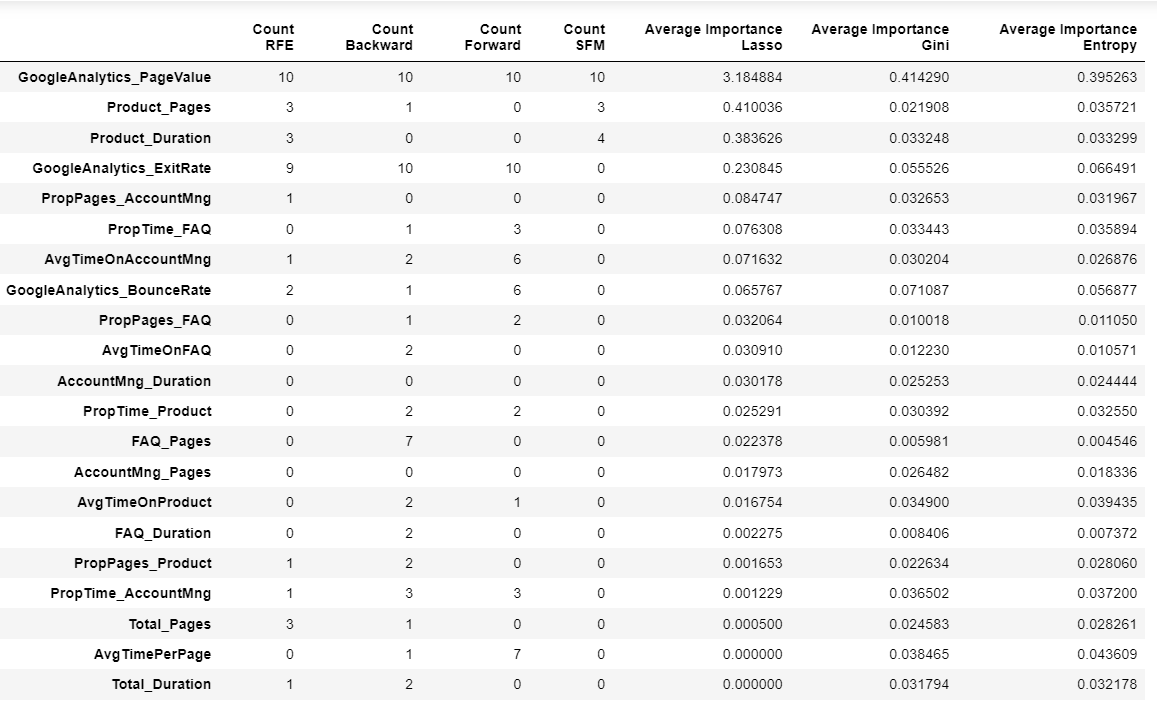

In [67]:
# Chi-Square for categorical data

fold = 1

for train_index, val_index in kf.split(data_non_metric, target):
        
        # Data Partition
        X_train, X_val = data_non_metric.iloc[train_index], data_non_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # CODE FOR Chi-Square
        if fold == 1:
            chi_square_results = pd.DataFrame(index = X_train.columns)
        
        importance_list = []
        
        for var in data_non_metric:
            
            dfObserved = pd.crosstab(y_train,X_train[var]) 
            chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)

            if p < 0.05:
                importance_list.append(True)
            else: 
                importance_list.append(False)
            
        selected_features = pd.Series(importance_list, index = X_train.columns, name=f'Partition {fold}')    
      
        chi_square_results = pd.concat((chi_square_results, selected_features), axis=1)
        
        fold+=1
        
        
# Add new column with count of True's        
count_chi_square_list = []
for index, row in chi_square_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_chi_square_list.append(count)

chi_square_results['Count'] = count_chi_square_list 

chi_square_results.sort_values(by='Count', ascending=False, inplace = True)

chi_square_results['Keep'] = chi_square_results['Count'].apply(lambda x: 'Yes' if x == 10 else 'No')
chi_square_results[chi_square_results['Keep'] == 'Yes']

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count,Keep
Apple,True,True,True,True,True,True,True,True,True,True,10,Yes
Mar,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_8,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_3,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_2,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_15,True,True,True,True,True,True,True,True,True,True,10,Yes
Windows,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_12,True,True,True,True,True,True,True,True,True,True,10,Yes
Oct,True,True,True,True,True,True,True,True,True,True,10,Yes
Nov,True,True,True,True,True,True,True,True,True,True,10,Yes


# Choose the most relevant features

In [68]:
selected_metric_variables = ['GoogleAnalytics_PageValue', 'GoogleAnalytics_ExitRate', 'Product_Pages', 'AvgTimeOnAccountMng']
selected_non_metric_variables= list(chi_square_results[chi_square_results['Keep'] == 'Yes'].index)

selected_variables= selected_metric_variables + selected_non_metric_variables

data_select_features = data[selected_variables]
#data_select_features[['Apple', 'Covid', 'Windows', 'Returner']] = data_select_features[['Apple', 'Covid', 'Windows', 'Returner']].astype('category')

data_select_features.head(3)

,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,AvgTimeOnAccountMng,Apple,Mar,Traffic_8,Traffic_3,Traffic_2,Traffic_15,...,Traffic_12,Oct,Nov,May,Traffic_13,Feb,Dec,Covid,New_Access,Returner
0,0.0,0.0667,3,0.0,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,0,True
1,0.0,0.0449,23,0.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,0,True
2,0.0,0.0583,8,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,0,True


In [69]:
data_select_features.describe().T

,count,mean,std,min,25%,50%,75%,max
GoogleAnalytics_PageValue,9857.0,6.046826,18.874397,0.0,0.0000,0.000,0.0000,361.7637
GoogleAnalytics_ExitRate,9857.0,0.041122,0.045789,0.0,0.0142,0.025,0.0481,0.2000
Product_Pages,9857.0,32.069494,44.734139,0.0,8.0000,18.000,38.0000,705.0000
AvgTimeOnAccountMng,9857.0,20.243932,45.682382,0.0,0.0000,5.850,24.4000,1566.6000


<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| AccountMng_Pages | Discard | Keep | Keep ?| Include in the model |
| AccountMng_Duration | Discard | Keep | Keep | Include in the model |
| FAQ_Pages | Discard | Discard | Keep | Try with and without |
| FAQ_Duration | Discard | Discard | Discard |  Discard |
| Product_Pages | Discard | Discard | Discard |  Discard |
| Product_Duration | Discard | Keep | Keep | Include in the model |
| GoogleAnalytics_BounceRate | Discard | Discard | Keep ? | Discard |
| GoogleAnalytics_ExitRate | Discard | Keep | Keep ?| Include in the model |
| GoogleAnalytics_PageValue | Discard | Keep | Keep | Include in the model |
| Total_Duration | Discard | Discard | Discard |  Discard |
| Total_Pages | Discard | Keep | Keep | Include in the model |
| PropTime_AccountMng | Discard | Discard | Discard |  Discard |
| PropTime_FAQ | Discard | Discard | Discard |  Discard |
| PropTime_Product | Discard | Keep | Keep | Include in the model |
| PropPages_AccountMng | Discard | Discard | Keep ? | Discard |
| PropPages_FAQ | Discard | Keep | Keep ?| Include in the model |
| PropPages_Product | Discard | Keep | Keep | Include in the model |
| AvgTimeOnAccountMng | Discard | Discard | Keep | Try with and without |
| AvgTimeOnFAQ | Discard | Discard | Keep | Try with and without |
| AvgTimeOnProduct | Discard | Discard | Keep | Try with and without |
| Month | Discard | Discard | Discard |  Discard | 


<hr>


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| OS | Keep |  
| Country | Discard | 
| Type_of_Visitor | Keep |

<hr>

# Model Evaluation

In [70]:
def avg_score(model, split_method, scaler_method, X, y):
    
    score_train = []
    score_val = []
    
    for train_index, test_index in split_method.split(X,y):
        
        # Data Partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # Separate X_train in metric and non metric features
        X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
        X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
        
        # Separate X_val in metric and non metric features
        X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
        X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)
        
        
        # Create a scalling method        
        scaler = scaler_method.fit(X_train_metric)
        
        # Scalling the X_train_metric
        X_train_metric_scaled = scaler.transform(X_train_metric) 
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)
        
        # Scalling the X_val_metric
        X_val_metric_scaled = scaler.transform(X_val_metric) 
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)
            
            
        # Join the X_train and X_val back together
        X_train_final = X_train_metric_scaled.join(X_train_non_metric)
        X_val_final = X_val_metric_scaled.join(X_val_non_metric)     

        
        # Define our model and fit to our scalled data
        model = model.fit(X_train_final, y_train)
        
        #value_train = model.score(X_train_final, y_train)
        #value_val = model.score(X_val_final, y_val)
        
        y_train_pred=model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        value_train=f1_score(y_train, y_train_pred)
        value_val = f1_score(y_val, y_val_pred)
        
        
        score_train.append(value_train)
        score_val.append(value_val)

    print('Average score of Train:', round(np.mean(score_train), 5))
    print('Average score of Valid:', round(np.mean(score_val), 5))
    print(f'Difference between Train and Validation: {round(np.mean(score_train)-np.mean(score_val), 5)}')

### Grids for parameters testing

In [71]:
# Traind test split
X_train, X_val, y_train, y_val = train_test_split(data_select_features, target, test_size = 0.2, random_state = 15, stratify = target)

# Decision Tree Grid
param_dt = {
    'criterion': ['gini'], #, 'entropy'],
    'splitter': ['best'], # 'random'],
    'max_depth': [2,3,4,5,6],
    
    'min_samples_split': [100,200,300],
    'min_samples_leaf': [100,200,300],
    
#    'min_weight_fraction_leaf': [0.0],
    'max_features': [2,4,6,8, None],
#   'random_state'=None,
    'max_leaf_nodes': [4,8,12, None],
#    'min_impurity_decrease'=0.0,
#    'min_impurity_split'=None,
#    'class_weight'=None,
#    'ccp_alpha'=0.0,
    }

grid_dt = GridSearchCV(DecisionTreeClassifier() , param_dt, scoring = 'f1')
grid_dt.fit(X_train, y_train)
grid_dt.best_params_, grid_dt.best_score_

KeyboardInterrupt: 

In [ ]:
# KNN Grid
param_grad_boost = {
    'max_depth':[4,6,8,10], 
    'min_samples_split':[50,100],
    'min_samples_leaf': [50,75],
    'subsample': [0.8,1],
    'n_estimators':range(100,1001,100),
    'learning_rate' : [ 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

grid_gb = GridSearchCV(estimator = GradientBoostingClassifier( max_features='sqrt', random_state=10), 
        param_grid = param_grad_boost, scoring='f1',n_jobs=4, cv=5)
grid_gb.fit(X_train,y_train)
grid_gb.best_params_, grid_nn.best_score_

In [111]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [411]:
# Neural Networks Grid
param_nn = {
#    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter' : [100],

    }

grid_nn = GridSearchCV(MLPClassifier(), param_grid = param_nn, n_jobs=-1, cv=10)
grid_nn.fit(X_train,y_train)
grid_nn.best_score_, grid_nn.best_params_

(0.8874458874458875,
 {'activation': 'tanh',
  'alpha': 0.05,
  'learning_rate': 'constant',
  'max_iter': 100,
  'solver': 'adam'})

In [370]:
# XGBoost grid
param_xgb = {
        'booster': ['gbtree'],
        # verbosity
        'max_depth': [3,5,8],
        'learning_rate': [0.05, 0.1, 0.3],
        'n_estimators': [100, 500, 1000],
        'colsample_bytree': [0.3, 0.7],
        'gamma':[1,5, 20],
        'min_child_weight': [1,1.5]
}

grid_xgb = GridSearchCV(XGBClassifier(), param_grid = param_xgb, scoring='accuracy', n_jobs=-1, cv=3)
grid_xgb.fit(X_train,y_train)
grid_xgb.best_score_, grid_xgb.best_params_

#params={ #'objective':'reg:squarederror',
#         'max_depth': range(2,15,3), 
#         'colsample_bylevel':0.5,
#         'learning_rate':0.01,
#         'random_state':20,
#         'min_child_weight':,
#         'gamma':

[14:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8971861471861472,
 {'booster': 'gbtree',
  'colsample_bytree': 0.7,
  'gamma': 5,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100})

### 1 - Change the model to use and its parameters

In [72]:
# ---------------  DECISION TREE ---------------
model_DT = DecisionTreeClassifier(    
    criterion='gini',
    max_depth= 4, 
    max_features= 4,
    splitter='best',
    max_leaf_nodes= 12,
    #min_samples_leaf= 100,
    #min_samples_split= 100,
    )


# --------------- KNN ---------------
model_KNN = KNeighborsClassifier(
#    n_neighbors=5,
#    *,
    weights='uniform',
#    algorithm='auto',
#    leaf_size=30,
#    p=2,
#    metric='minkowski',
#    metric_params=None,
#    n_jobs=None,
    )

# --------------- LOG FUNCTION ---------------
log_model = LogisticRegression() # Ganda miséria


# --------------- GRADIENT BOOST ---------------
grad_boost = GradientBoostingClassifier(
    
#    loss='deviance',
    learning_rate=0.01,
    n_estimators=1000,
    subsample= 0.8,
#    criterion='friedman_mse',
    min_samples_split= 50,
    min_samples_leaf= 40,
#    min_weight_fraction_leaf=0.0,
    max_depth= 8,
#    min_impurity_decrease=0.0,
#    min_impurity_split=None,
#    init=None,
#    random_state=None,
    max_features='sqrt',
#    verbose=0,
#    max_leaf_nodes=None,
#    warm_start=False,
#    validation_fraction=0.1,
#    n_iter_no_change=None,
#    tol=0.0001,
#   ccp_alpha=0.0,
    )



## ---------------------XGBoost ------------------  ACHO Q NAO SE PODE USAR
#
#xg_boost=XGBClassifier(
#    colsample_bytree = 0.7,
#    learning_rate = 0.05,
#    max_depth = 3,
#    n_estimators = 100,
#    min_child_weight = 1,
#    gamma = 5,
#    booster = 'gbtree',
#    verbosity = 1
#    #validate_parameters =False,
#    ##nthread [default to maximum number of threads available if not set],
#    #disable_default_eval_metric=True,
#    #enable_categorical=True
#)







# --------------- NEURAL NETWORKS ---------------
neural_networks = MLPClassifier(
    
    hidden_layer_sizes=(100,),
    activation='relu',
#    *,
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
#    learning_rate_init=0.001,
#    power_t=0.5,
    max_iter=200,
#    shuffle=True,
#    random_state=None,
#    tol=0.0001,
#    verbose=False,
#    warm_start=False,
#    momentum=0.9,
#    nesterovs_momentum=True,
#    early_stopping=False,
#    validation_fraction=0.1,
#    beta_1=0.9,
#    beta_2=0.999,
#    epsilon=1e-08,
#    n_iter_no_change=10,
#    max_fun=15000,
)

### 2- Change the way to split the dataset

In [73]:
# ---------- KFOLDS ----------
kf = StratifiedKFold(n_splits=10)


# ---------- REPEATED KFOLDS ----------
rkf2 = RepeatedKFold(n_splits=6, n_repeats=2)

# ---------- LEAVE ONE OUT ----------
loo = LeaveOneOut()

# ---------- LEAVE P OUT ----------
lpo = LeavePOut(p=1)

### 3- Change the way we scale the data

In [74]:
# ---------- MINMAX SCALER ----------
min_max = MinMaxScaler()
min_max2 = MinMaxScaler(feature_range = (-1,1))

# ---------- STANDARD SCALER ----------
standard_scaler = StandardScaler()

# ---------- ROBUST SCALER ----------
robust_scaler = RobustScaler()

### 4- Call the function above

In [75]:
avg_score(model = grad_boost,
          split_method = kf, 
          scaler_method = min_max, 
          X = data_select_features, 
          y = target
         )

Average score of Train: 0.66376
Average score of Valid: 0.66033
Difference between Train and Validation: 0.00342


# Choose the best model and the best scalling method

In [248]:
best_model = grad_boost
best_scalling = min_max

In [249]:
# Apply best_model and best_scalling to the dataset with the selected features
X_train, X_val, y_train, y_val = train_test_split(data_select_features, target, train_size=0.75, stratify = target, random_state=20)


# Separate X_train in metric and non metric features
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

# Separate X_val in metric and non metric features
X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)


# Create a scalling method        
best_scaler = best_scalling.fit(X_train_metric)

# Scalling the X_train_metric
X_train_metric_scaled = best_scaler.transform(X_train_metric) 
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)

# Scalling the X_val_metric
X_val_metric_scaled = best_scaler.transform(X_val_metric) 
X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)


# Join the X_train and X_val back together
X_train_final = X_train_metric_scaled.join(X_train_non_metric)
X_val_final = X_val_metric_scaled.join(X_val_non_metric)     


# Define our model and fit to our scalled data
best_model_fitted = best_model.fit(X_train_final, y_train)

#value_train = model.score(X_train_final, y_train)
#value_val = model.score(X_val_final, y_val)

y_train_pred=best_model.predict(X_train)
y_val_pred =best_model.predict(X_val)

value_train=f1_score(y_train, y_train_pred)
value_val = f1_score(y_val, y_val_pred)

print('Average score of Train:', round(np.mean(value_train), 5))
print('Average score of Valid:', round(np.mean(value_val), 5))
print(f'Difference between Train and Validation: {round(np.mean(value_train)-np.mean(value_val), 5)}')

Average score of Train: 0.66715
Average score of Valid: 0.66524
Difference between Train and Validation: 0.00191


In [225]:
data

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Apple,...,Browser_11,Browser_12,Browser_13,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8
0,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,0.0000,True,...,False,False,False,True,False,False,False,False,False,False
1,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,0.0000,False,...,False,False,False,True,False,False,False,False,False,False
2,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,0.0000,False,...,False,False,False,False,False,True,False,False,False,False
3,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,42.4225,False,...,False,False,False,True,False,False,False,False,False,False
4,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,True,...,False,False,False,True,False,False,False,False,False,False
9995,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,0.0000,False,...,False,False,False,False,False,False,False,False,False,False
9996,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,0.0000,True,...,False,False,False,True,False,False,False,False,False,False
9997,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,0.0000,False,...,False,False,False,True,False,False,False,False,False,False


In [263]:
#### Treinar best_model com todo o dataset train


X_train=data
y_train=target

# Separate X_train in metric and non metric features
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)




# Create a scalling method        
best_scaler = best_scalling.fit(X_train_metric)

# Scalling the X_train_metric
X_train_metric_scaled = best_scaler.transform(X_train_metric) 
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)


# Define our model and fit to our scalled data
best_model_fitted = best_model.fit(X_train_metric_scaled, y_train)



# Performance Measures

In [264]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [265]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [268]:
labels_train = best_model_fitted.predict(X_train)
labels_val = best_model_fitted.predict(X_val)

ValueError: X has 64 features, but DecisionTreeRegressor is expecting 21 features as input.

In [ ]:
metrics(y_train=y_train, pred_train=labels_train , y_val=y_val, pred_val=labels_val)

# Deployment

In [ ]:
test = pd.read_csv('test.csv')
test.head(3)

### Change type of variables

In [ ]:
test.Access_ID = test.Access_ID.astype('string') 
test.Date = pd.to_datetime(test.Date)
test.OS = test.OS.astype('string') 
test.Country = test.Country.astype('string') 
test.Type_of_Visitor = test.Type_of_Visitor.astype('string') 
test.Type_of_Traffic = test.Type_of_Traffic.astype('string') 
test.Browser = test.Browser.astype('string') 

test.info()

In [ ]:
## Pages and Duration variables
#account_index = test[(test['AccountMng_Pages']>1) & (test['AccountMng_Duration']==0) ].index  # --> 3
#len(account_index)
#test.drop(account_index, axis=0, inplace=True)
#test.loc[test['AccountMng_Duration']==0,'AccountMng_Duration'] = 1
#test
#
##test[(test['FAQ_Pages']==0) & (test['FAQ_Duration']!=0) ] # --> 0
#faq_index = test[(test['FAQ_Pages']>1) & (test['FAQ_Duration']==0) ].index # --> 9
#len(faq_index)
#test.drop(faq_index, axis=0, inplace=True)
#test.loc[test['FAQ_Duration']==0,'FAQ_Duration'] = 1
#test
#
##test[(test['Product_Pages']==0) & (test['Product_Duration']!=0) ] # --> 0
#product_index = test[(test['Product_Pages']>1) & (test['Product_Duration']==0) ].index # --> 130
#len(product_index)
#test.drop(product_index, axis=0, inplace=True)
#test.loc[test['Product_Duration']==0,'Product_Duration'] = 1
#test

# Total removed = 3 + 9 + 130 = 142 (1.42%)

### Create new variables

In [ ]:
# Create new variables

# Create binary variables for operating systems
test['Apple'] = test['OS'].apply(lambda x: bool(1) if x == 'MacOSX' or x == 'iOS' else bool(0))  
test['Windows'] = test['OS'].apply(lambda x: bool(1) if x == 'Windows' else bool(0))  
test['Android'] = test['OS'].apply(lambda x: bool(1) if x == 'Android' else bool(0))


# Create binary variables for countries
test['Portugal'] = test['Country'].apply(lambda x: str(1) if x == 'Portugal' else str(0)) 
test['Iberian_Peninsula'] = test['Country'].apply(lambda x: str(1) if x == 'Portugal' or x == 'Spain' else str(0))
test['Spain'] = test['Country'].apply(lambda x: str(1) if x == 'Spain' else str(0))


# Create binary variables for type of visitors
test['Returner'] = test['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'Returner' else bool(0)) 
test['New_Access'] = test['Type_of_Visitor'].apply(lambda x: str(1) if x == 'New_Access' else str(0))


# Create the total duration of the visits and total number of page visits
test['Total_Duration'] = test['AccountMng_Duration'] + test['FAQ_Duration'] + test['Product_Duration']
test['Total_Pages'] = test['AccountMng_Pages'] + test['FAQ_Pages'] + test['Product_Pages']

test.loc[test['Total_Pages']==0,'Total_Pages']=1


# Create the proportion of time on each page type
test['PropTime_AccountMng'] = test['AccountMng_Duration']/test['Total_Duration']
test['PropTime_FAQ'] = test['FAQ_Duration']/test['Total_Duration']
test['PropTime_Product'] = test['Product_Duration']/test['Total_Duration']

# Create the proportion of visited pages of each type
test['PropPages_AccountMng'] = test['AccountMng_Pages']/test['Total_Pages']
test['PropPages_FAQ'] = test['FAQ_Pages']/test['Total_Pages']
test['PropPages_Product'] = test['Product_Pages']/test['Total_Pages']

# Create the average time spent per page and type of page
test['AvgTimePerPage'] = test['Total_Duration'].div(test['Total_Pages'].values)

test['AvgTimeOnAccountMng'] = test['AccountMng_Duration'].div(test['AccountMng_Pages'].values)
test['AvgTimeOnFAQ'] = test['FAQ_Duration'].div(test['FAQ_Pages'].values)
test['AvgTimeOnProduct'] = test['Product_Duration'].div(test['Product_Pages'].values)

test.loc[test['AccountMng_Pages']==0,'AvgTimeOnAccountMng']=0
test.loc[test['FAQ_Pages']==0,'AvgTimeOnFAQ']=0
test.loc[test['Product_Pages']==0,'AvgTimeOnProduct']=0


### avg time per type of page?


# Create the month of the visit
test['Month'] = test['Date'].dt.month


# Create variable Covid
test['Covid'] = test['Month'].apply(lambda x: True if x>3 else False)


# Create dummy categorical variables

test['Month'] = test['Month'].apply(lambda x: calendar.month_abbr[x])
month = pd.DataFrame(pd.get_dummies(test['Month'], drop_first = True, dtype=bool))

test['Type_of_Traffic'] = test['Type_of_Traffic'].apply(lambda x: 'Traffic_'+str(x))
type_traffic = pd.DataFrame(pd.get_dummies(test['Type_of_Traffic'], drop_first = True, dtype=bool))

test['Browser'] = test['Browser'].apply(lambda x: 'Browser_'+str(x))
browser = pd.DataFrame(pd.get_dummies(test['Browser'], drop_first = True, dtype=bool))

test=pd.concat((test,month,type_traffic,browser), axis=1)


display(test.head(3))
print(test.shape)

In [ ]:
# best_model_fitted
# best_scaler

# Apply best_model_fitted and best_scaler to the dataset
test_data = test[selected_variables]

# Separate test_data in metric and non metric features
test_data_metric = test_data.select_dtypes(include=np.number).set_index(test_data.index)
test_data_non_metric = test_data.select_dtypes(exclude=np.number).set_index(test_data.index)


# Use best_scaler created above
test_data_metric_scaled = best_scaler.transform(test_data_metric) 
test_data_metric_scaled = pd.DataFrame(test_data_metric_scaled, columns = test_data_metric.columns).set_index(test_data.index)


# Join the test_data back together
test_data_final = test_data_metric_scaled.join(test_data_non_metric)


# Use best_model_fitted created above to create new columns called 'Buy'
test_data_final['Buy'] = best_model_fitted.predict(test_data_final)

display(test_data_final.head())

In [ ]:
test_data_final['Buy'].value_counts()

In [ ]:
test_data_final['Access_ID'] = test['Access_ID']

sample_submission = test_data_final[['Access_ID', 'Buy']]
sample_submission

In [ ]:
## Change name of file - TIAGO
#sample_submission.to_csv(r'C:\Users\tsoom\OneDrive\Documentos\IMS - Data Science\Machine Learning\Github Project\Project-Machine-Learning\submissions\GradBoost_MinMax2.csv', index=False, sep=',')
#
#text_file = open("sub15.txt", "w")
#n = text_file.write((str(best_model)))
#text_file.close()  # exportar também o modelo utilizado, alterar numero aqui e no csv para a correspondencia estar certa

In [267]:
# Change name of file  - JOHNNY
sample_submission.to_csv(r'C:\Users\Admin\Documents\GitHub\Project-Machine-Learning\submissions\24.csv', index=False, sep=',')

text_file = open("submissions/sub24.txt", "w")
n = text_file.write((str(best_model)+'\n\n'+str(selected_variables)+'\n\n'+ str(best_model)))
text_file.close()  # exportar também o modelo utilizado, alterar numero aqui e no csv para a correspondencia estar certa

In [ ]:
# !!!!!!!!!!!!!!!!!!  Melhor até agora DT3 com 0.67 de score !!!!!!!!!!!!!!!!!!